<a href="https://colab.research.google.com/github/CFVV/MSc-assignments/blob/main/T3_Skin_Lession_Classification%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto SLC: Skin Lession Classification (clasificación de lesiones de piel / lunares)
[Curso de Reconocimiento de Patrones](https://github.com/domingomery/patrones/)

Departamento de Ciencia de la Computación

Pontificia Universidad Catolica de Chile

Integrantes:

- Ignacio Astorga
- Camila Vera
- Javiera Inostroza - 16206797
- Samuel Zúñiga - 16637747
- Martín Ocqueteau - 15636453


---


En el proyecto se busca diseñar un reconocedor de 7 tipos distintos de lesiones. Estas 7 clases corresponden a:

- Clase 0: 'akiec' - actinic keratosis

- Clase 1: 'bcc' - basal cell carcinoma

- Clase 2: 'bkl' - benign keratosis

- Clase 3: 'df' - dermatofibroma

- Clase 4: 'mel' - melanoma

- Clase 5: 'nv' - melanocytic nevus

- Clase 6: 'vasc' - vascular lesion



# Setup inicial


In [ ]:
from IPython.display import clear_output

Descarga de PyXvis

In [ ]:
#!wget https://www.dropbox.com/s/54jfodpv1h4d0kl/pyxvis.zip
#!unzip pyxvis.zip
#!rm pyxvis.zip
clear_output()
print('PyXvis library downloaded.')

PyXvis library downloaded.


Instalación de PyBalu y PyXvis

In [ ]:
from IPython.display import clear_output
!pip install scipy==1.2
!pip3 install pybalu==0.2.5
!pip install ./pyxvis
clear_output()
print('PyBalu library installed.')
print('PyXvis library installed.')

PyBalu library installed.
PyXvis library installed.


Librerías para extracción de imágenes, selección de características. [Me faltan agregar más librerías aquí]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#from   google.colab.patches import cv2_imshow
import os, fnmatch
import cv2
from   tqdm.auto import tqdm
import numpy as np
from skimage.measure import label

In [ ]:
from pyxvis.features.extraction import extract_features

## Base de datos

Se utilizará la siguiente base de datos de lunares, la cual se divide en:


* `train`: 4200 imágenes a color y 4200 imágenes binarias de segmentación (600 por cada clase).

* `test`: 350 imágenes a color y 350 imágenes binarias de segmentación (50 por clase).

* `metadata`: Metadata registrada por personal médico por imagen.


In [ ]:
!wget https://www.dropbox.com/s/rdjxr5u0p4thc8j/lunares7p.zip
!unzip lunares7p.zip > unzip.txt
clear_output()
print('Base de datos cargada')

Base de datos cargada


Lectura de imágenes

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision
from   torchvision import transforms
from   torchvision.datasets import ImageFolder
from   torch.utils.data.dataloader import DataLoader
from   torch.utils.data import random_split
from   sklearn.metrics import confusion_matrix, accuracy_score

Se definen los directorios y se cargan las imágenes

In [ ]:
train_dir = "lunares7p/train/"
test_dir  = "lunares7p/test/"

train_set = ImageFolder(train_dir,transform = transforms.Compose([
    transforms.Resize((256,256)),transforms.RandomHorizontalFlip(),transforms.ToTensor()]))

test_set = ImageFolder(test_dir,transforms.Compose([
    transforms.Resize((256,256)),transforms.ToTensor()]))

img,_ = train_set[0]
print('Size image: '+ str(img.shape))
print('   Classes: ', train_set.classes)

Size image: torch.Size([3, 256, 256])
   Classes:  ['images', 'segmentation']


Se definen los conjuntos de entrenamiento y de prueba

In [ ]:
Xtrain = list()
Xtest = list()
ytrain = list()
ytest = list()

In [ ]:
for i in range(len(train_set)):
    if i in range(0, 600) or i in range(4200, 4800):
        class_ = 0
    elif i in range(600, 1200) or i in range(4800, 5400):
        class_ = 1
    elif i in range(1200, 1800) or i in range(5400, 6000):
        class_ = 2
    elif i in range(1800, 2400) or i in range(6000, 6600):
        class_ = 3
    elif i in range(2400, 3000) or i in range(6600, 7200):
        class_ = 4
    elif i in range(3000, 3600) or i in range(7200, 7800):
        class_ = 5
    elif i in range(3600, 4200) or i in range(7800, 8400):
        class_ = 6

    x = train_set.samples[i][0]
    img = plt.imread(x)
    Xtrain.append(img)
    ytrain.append(class_)

In [ ]:
for i in range(len(test_set)):
    if i in range(0, 50) or i in range(350, 400):
        class_ = 0
    elif i in range(50, 100) or i in range(400, 450):
        class_ = 1
    elif i in range(100, 150) or i in range(450, 500):
        class_ = 2
    elif i in range(150, 200) or i in range(500, 550):
        class_ = 3
    elif i in range(200, 250) or i in range(550, 600):
        class_ = 4
    elif i in range(250, 300) or i in range(600, 650):
        class_ = 5
    elif i in range(300, 350) or i in range(650, 700):
        class_ = 6

  # class_ = (i % 350) // 50  # Creo que esto es equivalente

    x = test_set.samples[i][0]
    img = plt.imread(x)
    Xtest.append(img)
    ytest.append(class_)

Se separan los conjuntos de training y testing en imágenes y segmentaciones

In [ ]:
Xtrain_img = Xtrain[:4200]
Xtrain_seg = Xtrain[4200:]
Xtest_img = Xtest[:350]
Xtest_seg = Xtest[350:]

ytrain_img = ytrain[:4200]
ytrain_seg = ytrain[4200:]
ytest_img = ytest[:350]
ytest_seg = ytest[350:]

## Funciones necesarias

In [ ]:
# Clasificación usando KNN con n_vecinos
def ClassifierKNN(Xtrain,ytrain,Xtest,ytest,n_vecinos=3,echo ='on'):
    knn = KNeighborsClassifier(n_neighbors=n_vecinos)
    knn.fit(Xtrain, ytrain)
    ypred        = knn.predict(Xtest)
    acc          = accuracy_score(ytest,ypred)
    C = confusion_matrix(ytest,ypred)
    if echo == 'on':
        print('Entrenando con '+str(Xtrain.shape[0])+' muestras y probando con '+str(Xtest.shape[0])+' muestras')
        print('Los datos tienen '+str(Xtrain.shape[1])+' features')

    acc_st = "{:.2f}".format(acc*100)

    print('Testing Accuracy = '+acc_st+'%')
    print()
    #print('Matriz de Confusión:')
    #print(C)
    heatmap(C, annot=True, cbar=None, cmap="Blues")
    plt.title("Confusion Matrix"), plt.tight_layout()
    plt.ylabel("True Class"), plt.xlabel("Predicted Class")
    plt.show()
    return acc,C




In [ ]:
def dirfiles(img_path,img_ext):
    img_names = fnmatch.filter(sorted(os.listdir(img_path)),img_ext)
    return img_names

In [ ]:
def GetChannels(img):
  # Retorna la imágen en escala de grises, rojo, verde y azúl.
    rgb_weights = [0.2989, 0.5870, 0.1140]
    gray_image = np.dot(img[...,:3], rgb_weights)
    red_image = img[:,:,0]
    green_image = img[:,:,1]
    blue_image = img[:,:,2]
    return (gray_image, red_image, green_image, blue_image)

# Extracción de características básicas de intensidad

(https://colab.research.google.com/drive/1PrBuK3vniTbpuKKdoCUrAqBYBhFI7T0r?usp=sharing#scrollTo=-aIm8OBNjJaM)

In [ ]:
from pyxvis.processing.images import gradlog
from skimage.measure import label

(256, 256)


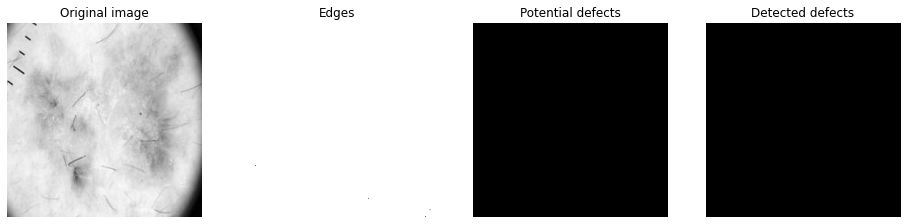

In [ ]:
for img in Xtrain_img:
    rgb_weights = [0.2989, 0.5870, 0.1140]
    img = np.dot(img[...,:3], rgb_weights)
    print(img.shape)
    (N,M) = img.shape
    e      = gradlog(img,1.25,4/250)
    L      = label(~e)         # labeling of objects
    n      = np.max(L)         # number of detected objects

    K1     = np.zeros((N,M), dtype=bool)
    K2     = np.zeros((N,M), dtype=bool)

    # Analysis of each segmented object
    for i in range(n):
        R = L == i                                # binary image of object i
        f = extract_features('basicgeo', bw=R*1)  # feature extraction for object i
        area = f[4]

        # recognition of potential defects according to the size
        if area > 10 and area < 40:
            K1 = np.bitwise_or(K1,R)
            i0 = int(round(f[0]))
            j0 = int(round(f[1]))
            h  = int(round(f[2]/2))
            w  = int(round(f[3]/2))
            i1 = max(i0-h,0)
            j1 = max(j0-w,0)
            i2 = min(i0+h,N-1)
            j2 = min(j0+w,M-1)
            I  = img[i1:i2,j1:j2]
            x  = extract_features('clp', img=I)
            if x[5]>0.4:
                K2 = np.bitwise_or(K2,R)
  fig, ax = plt.subplots(1, 4, figsize=(16, 8))
  ax[0].imshow(img, cmap='gray')
  ax[0].set_title('Original image')
  ax[0].axis('off')
  ax[1].imshow(e, cmap='gray')
  ax[1].set_title('Edges')
  ax[1].axis('off')
  ax[2].imshow(K1, cmap='gray')
  ax[2].set_title('Potential defects')
  ax[2].axis('off')
  ax[3].imshow(K2, cmap='gray')
  ax[3].set_title('Detected defects')
  ax[3].axis('off')
  plt.show()
  break

# Extracción de características de textura

Se extraen las texturas de Haralick y las características LBP del canal canal rojo de las imágenes y su escala de grises.

In [ ]:
from   pybalu.feature_extraction import lbp_features, hog_features, haralick_features, gabor_features

Para el train set:

In [ ]:
K = 7
N = 600

Mlbp = 6*6*59
Mhar = 28
# Mgab = 67

# TRAIN
Xlbp_gray_train = np.zeros((K*N, Mlbp))
Xhar_gray_train = np.zeros((K*N, Mhar))

Xlbp_red_train = np.zeros((K*N, Mlbp))
Xhar_red_train = np.zeros((K*N, Mhar))

# Xgab_gray_train = np.zeros((KN_train, Mgab))
# Xgab_red_train = np.zeros((KN_train, Mgab))


# GABOR

In [ ]:
Camila/Documentos/Magister/ProyectoPatrones/lunares7p/train/images/class_0
Camila/Documentos/Magister/ProyectoPatrones/lunares7p/train/images/class_0

In [ ]:
pwd

'/media/cami/CamiHDD/Camila/Documentos/Magister/ProyectoPatrones'

In [ ]:
fpath = 'train/images/class_'+str(j)+'/'
fpath

'train/images/class_0/'

In [ ]:
# Extracción de características del Training
K = 7 # 7 clases
N = 600 # imagenes por clase

Mgab = 39          # NUMERO DE ELEMENTOS DEL VECTOR DE gabor
Xgab_red_train_6  = np.zeros((K*N,Mgab))    # K*N muestras (filas), y Mhog características (columnas)
Xgab_gray_train_6 = np.zeros((K*N, Mgab))

y = np.zeros((K*N),'int')           # ground truth (clasificacion ideal)

t = 0
print('Cargando imagenes y extrayendo características...')

for j in range(K):            # para cada clase
    fpath = 'lunares7p/train/images/class_'+str(j)+'/'
    print('... de '+fpath)
    img_list = dirfiles(fpath,'*.jpg')
    print(j)

    for i in tqdm(range(N)):  # para cada imagen de la clase
        ### Lectura de la imagen
        img_path = fpath + img_list[i]
        img      = plt.imread(img_path)
        RGB_img  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_red  = RGB_img[:,:,1]
        gray, red, green, blue = GetChannels(img)

        ### Extracción de características
        # Gabor con 4 rotaciones y 4 escalas
        Xgab_red_train_6[t,:] = gabor_features(img_red, rotations=6, dilations=6)            # <= EXTRAE GABOR
        # Gabor con 4 rotaciones y 4 escalas
        Xgab_gray_train_6[t,:] = gabor_features(gray, rotations=6, dilations=6)            # <= EXTRAE GABOR

        y[t] = j # la muestra t pertenece a la clase j
        t = t+1

Cargando imagenes y extrayendo características...
... de lunares7p/train/images/class_0/
0



... de lunares7p/train/images/class_1/
1



... de lunares7p/train/images/class_2/
2



... de lunares7p/train/images/class_3/
3



... de lunares7p/train/images/class_4/
4



... de lunares7p/train/images/class_5/
5



... de lunares7p/train/images/class_6/
6


In [ ]:
np.save('Xgab_red_train_6.npy', Xgab_red_train_6) ## Correr solo si es necesario sobrescribir la matriz

In [ ]:
np.save('Xgab_gray_train_6.npy', Xgab_gray_train_6) ## Correr solo si es necesario sobrescribir la matriz

In [ ]:
# Extracción de características del Training
K = 7 # 7 clases
N = 50 # imagenes por clase

Mgab = 39          # NUMERO DE ELEMENTOS DEL VECTOR DE gabor
Xgab_red_test_6  = np.zeros((K*N,Mgab))    # K*N muestras (filas), y Mhog características (columnas)
Xgab_gray_test_6 = np.zeros((K*N, Mgab))

y = np.zeros((K*N),'int')           # ground truth (clasificacion ideal)

t = 0
print('Cargando imagenes y extrayendo características...')

for j in range(K):            # para cada clase
    fpath = 'lunares7p/test/images/class_'+str(j)+'/'
    print('... de '+fpath)
    img_list = dirfiles(fpath,'*.jpg')
    print(j)

    for i in tqdm(range(N)):  # para cada imagen de la clase
        ### Lectura de la imagen
        img_path = fpath + img_list[i]
        img      = plt.imread(img_path)
        RGB_img  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_red  = RGB_img[:,:,1]
        gray, red, green, blue = GetChannels(img)

        ### Extracción de características
        # Gabor con 4 rotaciones y 4 escalas
        Xgab_red_test_6[t,:] = gabor_features(img_red, rotations=6, dilations=6)            # <= EXTRAE GABOR
        # Gabor con 4 rotaciones y 4 escalas
        Xgab_gray_test_6[t,:] = gabor_features(gray, rotations=6, dilations=6)            # <= EXTRAE GABOR

        y[t] = j # la muestra t pertenece a la clase j
        t = t+1

Cargando imagenes y extrayendo características...
... de lunares7p/test/images/class_0/
0



... de lunares7p/test/images/class_1/
1



... de lunares7p/test/images/class_2/
2



... de lunares7p/test/images/class_3/
3



... de lunares7p/test/images/class_4/
4



... de lunares7p/test/images/class_5/
5



... de lunares7p/test/images/class_6/
6


In [ ]:
np.save('Xgab_red_test_6.npy', Xgab_red_test_6) ## Correr solo si es necesario sobrescribir la matriz

In [ ]:
np.save('Xgab_gray_test_6.npy', Xgab_gray_test_6) ## Correr solo si es necesario sobrescribir la matriz

## Concatenación train

In [ ]:
import numpy as np
import pandas as pd
import cv2
import PIL
import os, fnmatch
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
#from google.colab.patches import cv2_imshow
from scipy.ndimage.morphology import binary_fill_holes
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble  import RandomForestClassifier
from sklearn.svm import SVC
from tqdm.auto import tqdm
from   pybalu.feature_selection import sfs
from pybalu.feature_extraction import lbp_features, haralick_features, gabor_features,hog_features
from pybalu.feature_transformation import normalize, pca
from pybalu.feature_selection import sfs,clean
from pybalu.feature_analysis import jfisher
from pybalu.feature_extraction import fourier_des_features, hugeo_features, flusser_features, gupta_features,basic_geo_features
from mlxtend.feature_selection import SequentialFeatureSelector as mlxsfs
from sklearn.cross_decomposition import PLSRegression
print('Librerías cargadas.')

Librerías cargadas.


In [ ]:
Xgab_red_train_6 = np.load("Xgab_red_train_6.npy")
Xlbp_red_train =  np.load("Xlbp_red_train.npy")
X_Concat_train = np.concatenate((Xgab_red_train_6,Xlbp_red_train),axis =1)

In [ ]:
X_Concat_train.shape

(4200, 2163)

In [ ]:
Xgab_red_test_6 = np.load("Xgab_red_test_6.npy")
Xlbp_red_test =  np.load("Xlbp_red_test.npy")
X_Concat_test = np.concatenate((Xgab_red_test_6,Xlbp_red_test),axis =1)

In [ ]:
X_Concat_test.shape

(350, 2163)

normalizacion

In [ ]:
Xtrain_norm, a, b = normalize(X_Concat_train)
Xtest_norm        = X_Concat_test * a + b

datos train y test

In [ ]:
ytrain = np.load("ytrain_img.npy")
print("ytrain:", ytrain.shape)
ytest = np.load("ytest_img.npy")
print("ytest:", ytest.shape)


ytrain: (4200,)
ytest: (350,)


In [ ]:
#Xtrain
print("Xtrain_norm:", Xtrain_norm.shape)

#Xtest
print("Xtest_norm:", Xtest_norm.shape)



Xtrain_norm: (4200, 2163)
Xtest_norm: (350, 2163)


### CLASIFICACION TRAIN

In [ ]:
def performance(ygt,ypred):
    # ygt - ground truth (ideal class), ypred - prediction
    acc = accuracy_score(ygt,ypred)
    acc_st = "{:.2f}".format(acc*100)
    print('Accuracy = '+str(acc_st))
    C   = confusion_matrix(ygt,ypred)
    print('Confusion Matrix:')
    print(C)
    return acc,C

## KNN

In [ ]:
# 1. Definición del Clasificador
knn_lbp_gab = KNeighborsClassifier(n_neighbors = 3)

# 2. Entrenamiento (Xtrain, ytrain)
knn_lbp_gab.fit(Xtrain_norm, ytrain)

# 3. Predicción en el val (Xtest)
ypred = knn_lbp_gab.predict(Xtrain_norm)

# 4. Accuracy
acc,C = performance(ytrain,ypred)

Accuracy = 80.90
Confusion Matrix:
[[553   3  23  12   8   1   0]
 [114 421  24  12  15   8   6]
 [ 68  51 424   7  29  16   5]
 [  1   1   1 594   0   0   3]
 [ 52  46  35  17 436  10   4]
 [ 14  28  33  27  27 468   3]
 [ 15  25  10  19  15  14 502]]


### CLASIFICACION TEST

In [ ]:
n = 150
acc_knn = np.zeros((n,))
acc_max = 0
for j in range(n):
    k = j+1
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(Xtrain_norm, ytrain)
    ypred        = clf.predict(Xtest_norm)
    acc_knn[j]   = accuracy_score(ypred,ytest)
    if acc_knn[j]>acc_max:
        acc_max = acc_knn[j]
        kmax = k
    print(str(k)+' > '+str(acc_knn[j])+'*** max')

plt.plot(range(1,n+1),acc_knn)
plt.ylabel('acc')
plt.xlabel('n_vecinos')

1 > 0.40285714285714286*** max
2 > 0.34*** max
3 > 0.3314285714285714*** max
4 > 0.34285714285714286*** max
5 > 0.3514285714285714*** max
6 > 0.35714285714285715*** max
7 > 0.36857142857142855*** max
8 > 0.35428571428571426*** max
9 > 0.35714285714285715*** max
10 > 0.35714285714285715*** max
11 > 0.35428571428571426*** max
12 > 0.34*** max
13 > 0.34*** max
14 > 0.35428571428571426*** max
15 > 0.3514285714285714*** max
16 > 0.3314285714285714*** max
17 > 0.34*** max
18 > 0.3628571428571429*** max
19 > 0.35428571428571426*** max
20 > 0.35714285714285715*** max
21 > 0.3514285714285714*** max
22 > 0.37142857142857144*** max
23 > 0.36*** max
24 > 0.36857142857142855*** max
25 > 0.36857142857142855*** max
26 > 0.3657142857142857*** max
27 > 0.3514285714285714*** max
28 > 0.35714285714285715*** max
29 > 0.36*** max
30 > 0.35428571428571426*** max
31 > 0.3485714285714286*** max
32 > 0.3514285714285714*** max
33 > 0.36*** max
34 > 0.3657142857142857*** max
35 > 0.3485714285714286*** max
36 > 0

KeyboardInterrupt: 

In [ ]:
# 1. Definición del Clasificador
knn_lbp_gab = KNeighborsClassifier(n_neighbors =14)  #k=7 ->36.9

# 2. Entrenamiento (Xtrain, ytrain)
knn_lbp_gab.fit(Xtrain_norm, ytrain)

# 3. Predicción en el val (Xtest/val)
ypred = knn_lbp_gab.predict(Xtest_norm)

# 4. Accuracy
acc,C = performance(ytest,ypred)

Accuracy = 35.43
Confusion Matrix:
[[34  6  4  3  3  0  0]
 [18 11  8  6  6  1  0]
 [12  8 14  4  7  4  1]
 [ 9  7  7 16  8  3  0]
 [11  3  9  7 13  6  1]
 [ 1  5  2 11  4 24  3]
 [ 2  9  4  3 11  9 12]]


## RANDOM FOREST

Train

In [ ]:
# 1. Definición del Clasificador
rf_lbp_gab = RandomForestClassifier(max_depth=16)

# 2. Entrenamiento (Xtrain, ytrain)
rf_lbp_gab.fit(Xtrain_norm, ytrain)

# 3. Predicción en el val (Xtest)
ypred = rf_lbp_gab.predict(Xtrain_norm)

# 4. Accuracy
acc,C = performance(ytrain,ypred)

Accuracy = 100.00
Confusion Matrix:
[[600   0   0   0   0   0   0]
 [  0 600   0   0   0   0   0]
 [  0   0 600   0   0   0   0]
 [  0   0   0 600   0   0   0]
 [  0   0   0   0 600   0   0]
 [  0   0   0   0   0 600   0]
 [  0   0   0   0   0   0 600]]


Test

In [ ]:
# 1. Definición del Clasificador
rf_lbp_gab = RandomForestClassifier(max_depth=17)

# 2. Entrenamiento (Xtrain, ytrain)
rf_lbp_gab.fit(Xtrain_norm, ytrain)

# 3. Predicción en el val (Xtest/val)
ypred = rf_lbp_gab.predict(Xtest_norm)

# 4. Accuracy
acc,C = performance(ytest,ypred)

Accuracy = 39.43
Confusion Matrix:
[[28  6  8  5  3  0  0]
 [ 9 23  5  8  3  1  1]
 [ 6  7 13  7  8  6  3]
 [ 5  6  9 16  4  9  1]
 [ 7  5 11  1 16  7  3]
 [ 0  8  1  4  6 23  8]
 [ 0  7  3  3  5 13 19]]
